In [675]:
# Importation des bibliothèques os (pour les opérations sur le système de fichiers) et pandas (pour la manipulation de données)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Définition d'une fonction nommée 'get_file_path' qui prend deux paramètres : 'subdirectory' (sous-répertoire) et 'filename' (nom du fichier)
def get_file_path(subdirectory, filename):
    # La fonction combine le répertoire de travail actuel ('os.getcwd()'), le sous-répertoire et le nom de fichier pour former un chemin complet.
    file_path = os.path.join(os.getcwd(), subdirectory, filename)
    # La fonction retourne le chemin complet résultant.
    return file_path

# Appel de la fonction 'get_file_path' avec les arguments "Datasets" (sous-répertoire) et "ks_clean_data.csv" (nom de fichier)
file_path = get_file_path("Datasets", "ks_clean_data.csv")

# Utilisation de pandas pour lire un fichier CSV ('file_path') avec un encodage spécifique ('encoding') et en utilisant seulement les premières 13 colonnes ('usecols').
df = pd.read_csv(file_path)

# **Étape 7 : Créer un TestSet**

Bien qu'il peut parraître étrange de créer un TestSet, à cette étape, avant même d'avoir analysé profondément les données, leurs interrelations et leur incidence sur la variable indépendante, il est important de le faire afin de minimiser le biais de recherche important, communément appelé *Data snooping bias*. 

Nous utilisons ici une méthode d'échantillonnage stratifié, pour avoir un représentation adéquate de la variable prédite *State*, dans notre test et train sets. Le cutoff point que nous utilisons pour le test_size est de 80/20, qui est la pratique courante dans les contextes volumétrique comme le présent.

In [676]:
from sklearn.model_selection import StratifiedShuffleSplit

# Crée un split stratifié entre le train et le test, pour assurer que nous avons suffisamment de classe de State dans le test_set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in split.split(df, df['Success']):
        strat_train_set = df.loc[train_index]
        strat_test_set = df.loc[test_index]

In [677]:
# Validation que le test set est bel et bien stratifié
print('Répartition de Success dans le test_set')
print(strat_test_set['Success'].value_counts() / len(strat_test_set))
print('\nRépartition de Success dans le train_set')
print(strat_train_set['Success'].value_counts() / len(strat_train_set))

Répartition de Success dans le test_set
0    0.658837
1    0.341163
Name: Success, dtype: float64

Répartition de Success dans le train_set
0    0.658844
1    0.341156
Name: Success, dtype: float64


In [678]:
# Séparer les datasets en features et labels pour les transformations.
X_test = strat_test_set.drop('Success', axis=1)
y_test = strat_test_set['Success'].copy()

# **Étape 8 : Analyse et visualisation des variables afin d'extraire des insights**

Jusqu’à présent, nous n’avons jeté qu’un coup d'oeil aux données pour avoir une compréhension générale du format de données que nous manipulons. L’objectif est maintenant d’aller un peu plus en profondeur. Espérons que les sections précédentes nous ont donné une idée de quelques façons dont nous pouvons explorer les données et obtenir des informations.


In [679]:
# Crée une copie du strat_train_set pour conserver son intégrité vu que nous transformerons les données.
train_set = strat_train_set.copy()

#### **Étape 8.1 : Vérifier la prévalence de la variable *Success* dans chaque groupe des variables catégorielles**

In [680]:
# Crée une fonction de prévalence qui est particulièrement pertinente lorsqu'on veut tirer des insights d'une classification.
def calc_prevalence(y):
    # Calcule la somme des valeurs dans la liste y, qui sont généralement des étiquettes de classification (1 ou 0).
    total_positives = sum(y)
    # Calcule la longueur de la liste y, qui représente le nombre total d'échantillons ou d'observations.
    total_samples = len(y)
    # Calcule la prévalence en divisant le nombre total de positifs par le nombre total d'échantillons.
    prevalence = total_positives / total_samples
    
    # Retourne la prévalence calculée.
    return total_positives, total_samples, prevalence

# Validation que la fonction fonctionne.
calc_prevalence(train_set['Success'])

(85634, 251011, 0.34115636366533736)

In [681]:
'''
NOTE : Avant de commencer la vérification de prévalence entre les variables concernées, nous pouvons créer des variables 
catégorielle pour explorer, ce qu'on pourrait faire plus tard, pour le feature engineering.
'''

# Potentiellement, le jour, le mois, l'année auxquels le projet a été lancé peut avoir une incidence sur la prévalence.
train_set['Deadline'] = pd.to_datetime(train_set['Deadline'], format='%Y-%m-%d %H:%M:%S')
train_set['Launched'] = pd.to_datetime(train_set['Launched'], format='%Y-%m-%d %H:%M:%S')

train_set['DayLaunched'] = train_set['Launched'].dt.day
train_set['MonthLaunched'] = train_set['Launched'].dt.month
train_set['YearLaunched'] = train_set['Launched'].dt.year

# Quels jours de la semaine le projet a été lancé.
train_set['WeekdayLaunched'] = train_set['Launched'].dt.weekday
train_set['HourLaunched'] = train_set['Launched'].dt.hour
train_set['TimeLaunched'] = train_set['HourLaunched'].apply(
    lambda x: 'Morning' if 11 >= x >= 5 else 'Afternoon' if 16 >= x >= 12 else 'Evening' if 20 >= x >= 17 else 'Night')

In [682]:
#Validation des explorations.
train_set.head(1)

,ID,Name,Category,MainCategory,Currency,Deadline,Goal,Launched,Pledged,Backers,Country,Success,DayLaunched,MonthLaunched,YearLaunched,WeekdayLaunched,HourLaunched,TimeLaunched
154406,1947487012,glacious le the first affordable 60mm ice sphe...,Product Design,Design,USD,2014-12-25 18:56:41,10000.0,2014-11-25 18:56:41,15962.0,128,US,1,25,11,2014,1,18,Evening


In [683]:
def prev_by_group(column):
    # Groupe le 'train_set' par la colonne 'Category' et calcule la prévalence de la variable 'Success' dans chaque groupe.
    category_prev = train_set.groupby(column).apply(lambda x: calc_prevalence(x['Success'].values))

    # Tri les données en fonction de la prévalence (la troisième valeur dans chaque élément de tuple) de manière décroissante.
    sorted_data = sorted(category_prev.items(), key=lambda x: x[1][2], reverse=True)

    # Imprime, montrant chaque catégorie avec ses valeurs associées.
    for category, values in sorted_data:
        print(f"{category}: {values}")

2011: (9576, 20837, 0.459567116187551)
2010: (3676, 8447, 0.4351840890256896)
2009: (452, 1047, 0.43170964660936006)
2012: (13743, 32235, 0.42633783154955796)
2013: (14599, 34628, 0.4215952408455585)
2014: (15863, 52434, 0.302532707785025)
2016: (12135, 41871, 0.2898187289532134)
2015: (15590, 59512, 0.2619639736523726)


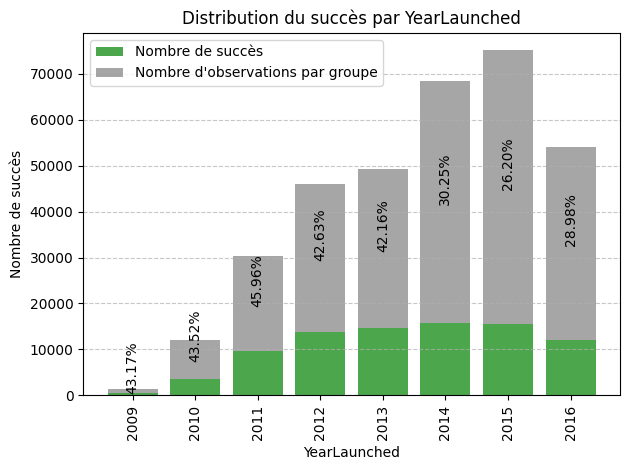

In [684]:
# Regroupe les données par 'YearLaunched' et calcule la somme de 'Success' pour chaque année.
def histogram_values(column,descending,show_groups):
    groups = train_set.groupby(column)['Success'].agg(['sum', 'count'])
    
    # Calcule la proportion de 'Success'
    groups['proportion'] = groups['sum'] / groups['count']

    # Si show_group == 0, cela veut dire montre tous les groupes.
    if descending == 1 and show_groups > 0:
        # Tri les données par la proportion
        groups = groups.sort_values(by=['proportion'], ascending=False)
        # Montre n nombre d'observations.
        groups = groups.head(show_groups)

    elif descending == 0 and show_groups > 0:
        groups = groups.head(show_groups)

    elif descending == 1 and show_groups == 0:
        groups = groups.sort_values(by=['proportion'], ascending=False)
    else:
        pass
       

    # Crée un histogramme
    fig, ax = plt.subplots()
    ax.bar(groups.index, groups['sum'], label='Nombre de succès', color='green', alpha=0.7,tick_label=groups.index)
    ax.bar(groups.index, groups['count'], label='Nombre d\'observations par groupe',color='gray', alpha=0.7, bottom=groups['sum'])

    # Définit les étiquettes des axes et le titre
    ax.set_xlabel(column)
    ax.set_ylabel('Nombre de succès')
    ax.set_title(f'Distribution du succès par {column}')

    # Montre les proportions dans le graphique. 
    for i, row in groups.iterrows():
        ax.annotate(f'{row["proportion"]:.2%}', (i, row['sum'] + row['count'] / 2), ha='center', rotation=90)

    # Montre la légende
    ax.legend()

    # Affiche et personnalise le graphique
    plt.grid(axis='y', linestyle='--', alpha=0.7) 
    plt.xticks(rotation=90)  
    plt.tight_layout() 
    plt.show()

# En quelle année le projet a été lancé? 
prev_by_group('YearLaunched')
histogram_values('YearLaunched',descending=0,show_groups=0)

Indie Rock: (2755, 4298, 0.640995812005584)
Dance: (1697, 2692, 0.6303863298662704)
Country & Folk: (2067, 3280, 0.6301829268292682)
Classical Music: (1181, 1890, 0.6248677248677249)
Theater: (4200, 7012, 0.5989731888191672)
Jazz: (778, 1319, 0.5898407884761183)
Plays: (528, 924, 0.5714285714285714)
Comic Books: (811, 1485, 0.5461279461279461)
Shorts: (5061, 9379, 0.5396097664996268)
Rock: (2604, 5051, 0.5155414769352603)
Graphic Novels: (536, 1055, 0.5080568720379147)
Public Art: (1136, 2245, 0.5060133630289533)
Comics: (2107, 4254, 0.49529854254818995)
Tabletop Games: (3733, 7699, 0.48486816469671384)
Illustration: (887, 1848, 0.479978354978355)
Art Books: (829, 1749, 0.47398513436249284)
Pop: (1119, 2384, 0.46937919463087246)
World Music: (682, 1490, 0.4577181208053691)
Performance Art: (695, 1619, 0.42927733168622606)
Art: (2800, 6978, 0.40126110633419315)
Sculpture: (513, 1283, 0.39984411535463754)
Music: (5192, 13161, 0.3944988982600106)
Periodicals: (351, 909, 0.3861386138613861

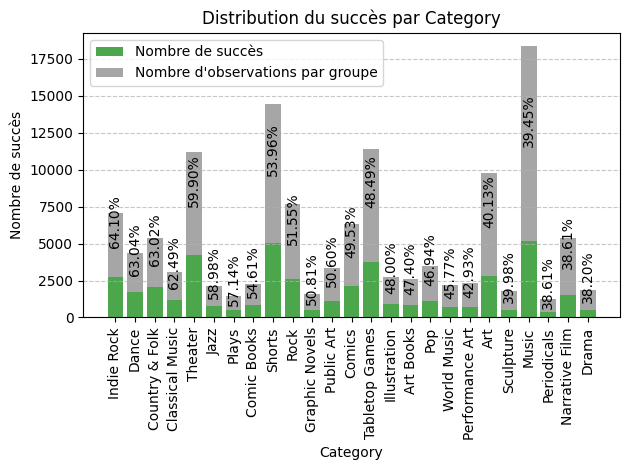

In [685]:
# Quelle était la catégorie?
prev_by_group('Category')
histogram_values('Category',descending=1,show_groups=25)

Dance: (1697, 2692, 0.6303863298662704)
Theater: (4728, 7936, 0.5957661290322581)
Comics: (3454, 6794, 0.5083897556667648)
Music: (17306, 37143, 0.46592897719624154)
Art: (7720, 19043, 0.40539830908995433)
Film & Video: (16797, 45119, 0.37228218710521066)
Design: (5248, 17732, 0.29596210241371534)
Publishing: (8019, 27119, 0.29569674398023527)
Photography: (2250, 7626, 0.2950432730133753)
Games: (6023, 20512, 0.2936329953198128)
Food: (4124, 16672, 0.2473608445297505)
Crafts: (1358, 5756, 0.2359277275886032)
Fashion: (3235, 14481, 0.22339617429735514)
Journalism: (645, 3213, 0.20074696545284781)
Technology: (3030, 19173, 0.15803473634798937)


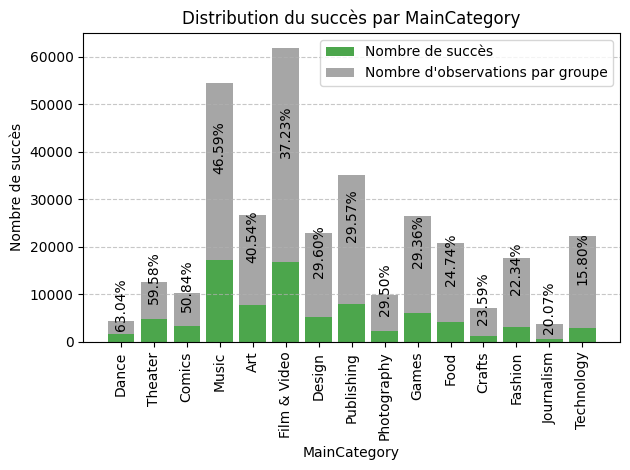

In [686]:
# Quelle était la catégorie principale?
prev_by_group('MainCategory')
histogram_values('MainCategory',descending=1,show_groups=0)

USD: (72705, 202613, 0.358836797244007)
GBP: (7210, 21965, 0.32824948782153424)
NZD: (242, 881, 0.2746878547105562)
DKK: (145, 568, 0.25528169014084506)
CAD: (2306, 9473, 0.24342869207220522)
SEK: (192, 827, 0.23216444981862153)
SGD: (20, 92, 0.21739130434782608)
AUD: (1068, 4914, 0.21733821733821734)
NOK: (69, 365, 0.18904109589041096)
EUR: (1609, 8743, 0.18403294063822487)
CHF: (62, 363, 0.17079889807162535)
HKD: (4, 62, 0.06451612903225806)
MXN: (2, 145, 0.013793103448275862)


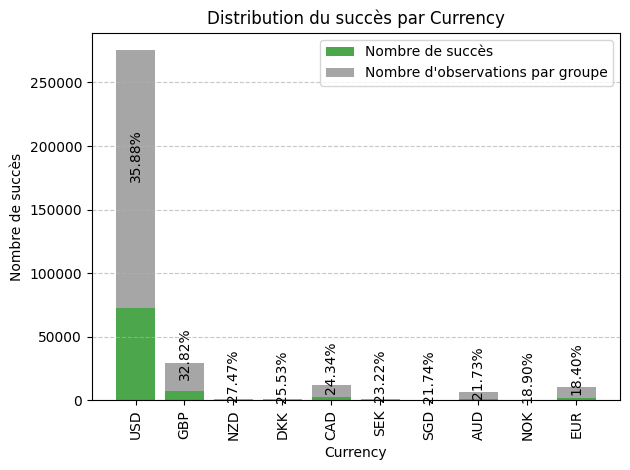

In [687]:
# Dans quelle devise le projet était financé?
prev_by_group('Currency')
histogram_values('Currency', descending=1,show_groups=10)

US: (72705, 202613, 0.358836797244007)
GB: (7210, 21965, 0.32824948782153424)
NZ: (242, 881, 0.2746878547105562)
FR: (378, 1452, 0.2603305785123967)
DK: (145, 568, 0.25528169014084506)
IE: (109, 439, 0.24829157175398633)
CA: (2306, 9473, 0.24342869207220522)
SE: (192, 827, 0.23216444981862153)
SG: (20, 92, 0.21739130434782608)
AU: (1068, 4914, 0.21733821733821734)
NO: (69, 365, 0.18904109589041096)
DE: (382, 2057, 0.1857073407875547)
BE: (53, 303, 0.17491749174917492)
NL: (306, 1773, 0.17258883248730963)
CH: (62, 363, 0.17079889807162535)
ES: (175, 1053, 0.16619183285849953)
AT: (41, 301, 0.1362126245847176)
IT: (165, 1365, 0.12087912087912088)
HK: (4, 62, 0.06451612903225806)
MX: (2, 145, 0.013793103448275862)


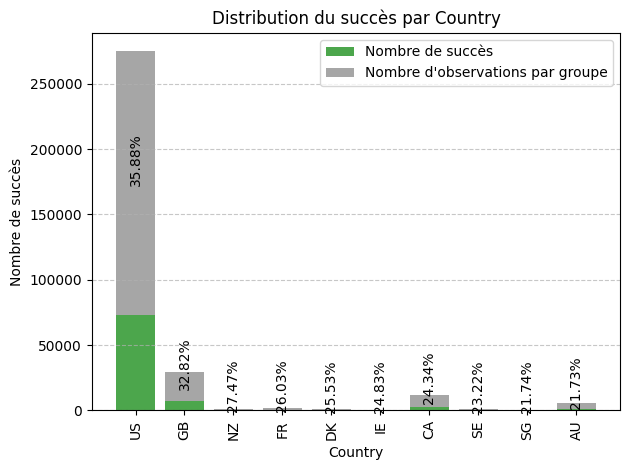

In [688]:
# Dans quel pays le projet a été lancé?
prev_by_group('Country')
histogram_values('Country',descending=1,show_groups=10)

1: (3902, 10277, 0.379682786805488)
2: (3191, 8835, 0.3611771363893605)
19: (2924, 8270, 0.3535671100362757)
3: (2978, 8436, 0.3530109056424846)
7: (2903, 8313, 0.34921207746902444)
13: (2835, 8188, 0.34623839765510506)
15: (2968, 8599, 0.3451564135364577)
12: (2887, 8371, 0.3448811372595867)
4: (2879, 8362, 0.344295623056685)
6: (2796, 8142, 0.34340456890198967)
8: (2917, 8506, 0.34293439924758995)
5: (2829, 8256, 0.34265988372093026)
25: (2573, 7511, 0.34256423911596323)
21: (2863, 8402, 0.3407522018567008)
20: (2750, 8108, 0.33917118894918596)
10: (2937, 8666, 0.3389106854373413)
31: (1538, 4549, 0.3380962848977797)
26: (2507, 7419, 0.33791616120770995)
16: (2771, 8202, 0.3378444281882468)
24: (2590, 7719, 0.33553569115170356)
18: (2754, 8213, 0.3353220504078899)
17: (2724, 8137, 0.3347671131866781)
14: (2765, 8288, 0.33361486486486486)
28: (2547, 7656, 0.33268025078369906)
23: (2604, 7860, 0.33129770992366414)
27: (2447, 7389, 0.3311679523616186)
30: (2392, 7227, 0.3309810433098104

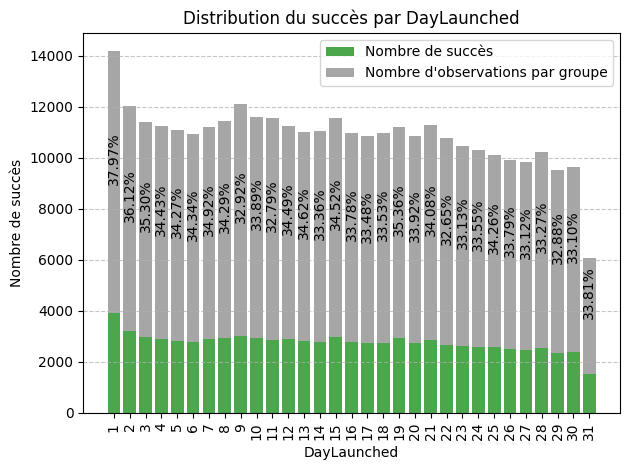

In [689]:
# À quelle jour du mois le projet a été lancé?
prev_by_group('DayLaunched')
histogram_values('DayLaunched',descending=1,show_groups=0)

3: (8188, 22243, 0.3681158117160455)
4: (7878, 21565, 0.36531416647345233)
2: (7254, 19933, 0.36391912908242613)
5: (7761, 21692, 0.35778167066199523)
10: (7822, 22215, 0.35210443394103086)
9: (7323, 20836, 0.35145901324630446)
6: (7659, 21811, 0.3511530878914309)
1: (5952, 18139, 0.3281327526324494)
8: (6914, 21621, 0.3197816937236946)
12: (4414, 14011, 0.31503818428377706)
7: (7736, 24989, 0.3095762135339549)
11: (6733, 21956, 0.3066587720896338)


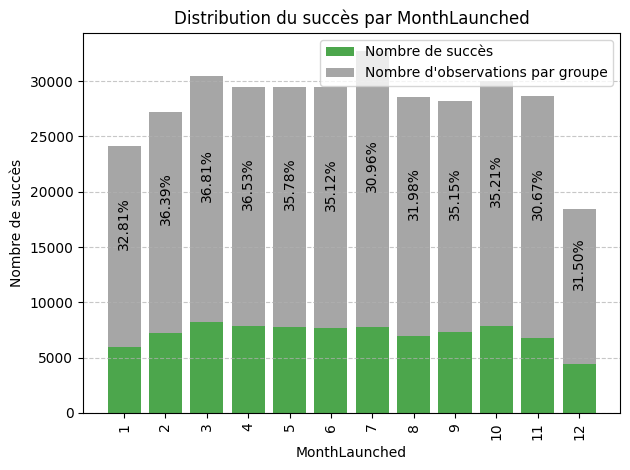

In [690]:
# À quelle mois de l'année le projet a été lancé?
prev_by_group('MonthLaunched')
histogram_values('MonthLaunched',descending=1,show_groups=0)

1: (17460, 50107, 0.3484543077813479)
3: (14111, 40818, 0.3457053260816306)
6: (4705, 13652, 0.34463814825666567)
2: (15381, 44741, 0.34377863704432177)
0: (13651, 40181, 0.3397376869664767)
4: (13220, 39475, 0.3348955034832172)
5: (7106, 22037, 0.3224576848028316)


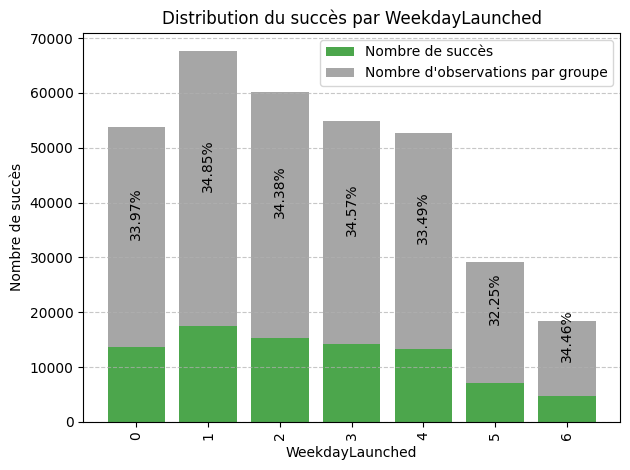

In [691]:
# À quelle journée de semaine le projet a été lancé? (0=Lundi, 6 = Dimanche)
prev_by_group('WeekdayLaunched')
histogram_values('WeekdayLaunched',descending=1,show_groups=0)

14: (2635, 6604, 0.3990006056935191)
15: (3538, 8908, 0.39717108217332736)
16: (4541, 12101, 0.3752582431204033)
13: (1784, 4781, 0.37314369378791046)
6: (2667, 7373, 0.36172521361725213)
17: (5515, 15587, 0.35382049143517036)
18: (6239, 17839, 0.34973933516452715)
19: (5900, 17082, 0.3453928111462358)
12: (1313, 3860, 0.3401554404145078)
9: (1563, 4602, 0.3396349413298566)
4: (3038, 8975, 0.3384958217270195)
5: (2701, 8022, 0.33669907753677386)
7: (1864, 5581, 0.33399032431463893)
2: (3848, 11570, 0.3325842696629214)
8: (1521, 4589, 0.3314447592067989)
3: (3389, 10231, 0.3312481673345714)
20: (5653, 17091, 0.3307588789421333)
1: (4424, 13415, 0.329780096906448)
23: (5381, 16502, 0.32608168706823415)
22: (5469, 16795, 0.3256326287585591)
10: (1159, 3584, 0.32338169642857145)
21: (5666, 17556, 0.322738664843928)
0: (4815, 15159, 0.3176330892539086)
11: (1011, 3204, 0.3155430711610487)


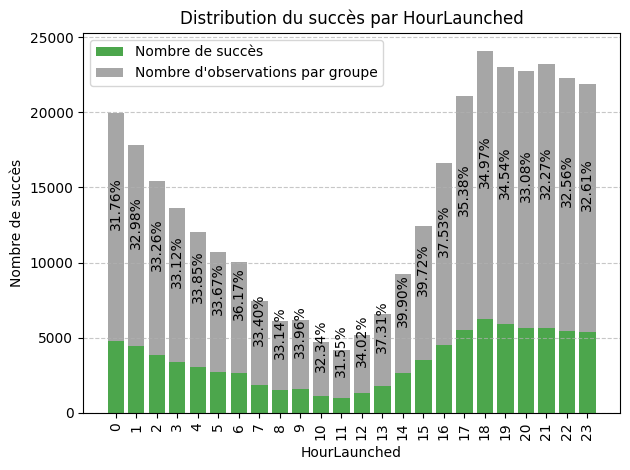

In [692]:
# À quelle heure de la journée le projet a été lancée?
prev_by_group('HourLaunched')
histogram_values('HourLaunched',descending=1,show_groups=0)

Afternoon: (13811, 36254, 0.3809510674684173)
Evening: (23307, 67599, 0.3447832068521724)
Morning: (12486, 36955, 0.3378703828981193)
Night: (36030, 110203, 0.32694209776503363)


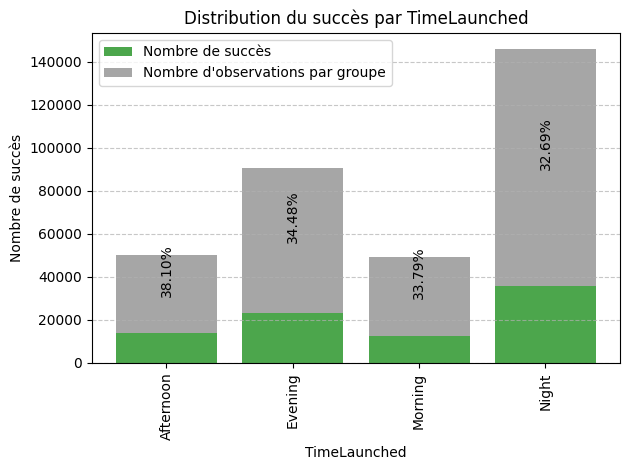

In [693]:
# À quel moment de la journée le projet a été lancée?
prev_by_group('TimeLaunched')
histogram_values('TimeLaunched',descending=1,show_groups=0)

#### **Étape 8.2 : Vérifier la corrélation entre la variable *Success* et les variables numériques**

In [694]:
'''
NOTE : Avant de commencer la vérification de corrélation entre les variables concernées, nous pouvons créer des variables 
numériques pour explorer, ce qu'on pourrait faire plus tard, pour le feature engineering.
'''

# Potentiellement, la longueur du titre du projet pourrait avoir une corrélation.
train_set['Name'] = train_set['Name'].astype(str)
train_set['LengthName'] = train_set['Name'].apply(lambda x : len(x))

# Potentiellement, la délai entre le Deadline et Launched du projet pourrait avoir une corrélation.
train_set['DateDiff']=(train_set['Deadline']-train_set['Launched']).dt.days

# Comme nous avons vu que les log et les racines carées de variables numériques étaient plus stables dans la distribution, nous pouvons les explorer.
columns = ['Goal','Pledged','Backers']

for column in columns:
    train_set[f'log_{column}'] = train_set[column].apply(lambda x : np.log(x))

for column in columns:
    train_set[f'sqrt_{column}'] = train_set[column].apply(lambda x : np.sqrt(x))

In [695]:
# Regardons si le nombre de projets lancés au cours d'un jour de lancement donné a une incidence sur le succès.

# Crée un nouveau Dataframe qui contient le compte de projet par jour
train_set['DateLaunched'] = train_set['Launched'].apply(lambda x : x.date())
date_counts = train_set['DateLaunched'].value_counts().reset_index()
date_counts.columns = ['DateLaunched', 'CountDay']

# Joint CountDay aux données du train_set
train_set = train_set.reset_index().merge(date_counts, how="left").set_index('index')

In [696]:
# Regardons si le nombre de projets lancés au cours d'un mois de lancement donné a une incidence sur le succès.

# Crée un nouveau Dataframe qui contient le compte de projet par jour
train_set['MonthYear'] = train_set['Launched'].dt.strftime('%B %Y')
month_count = train_set['MonthYear'].value_counts().reset_index()
month_count.columns = ['MonthYear', 'CountMonth']

# Joint CountDay aux données du train_set
train_set = train_set.reset_index().merge(month_count, how="left").set_index('index')

In [697]:
# Regardons si le nombre de projets lancés au cours d'un mois de lancement donné a une incidence sur le succès.

# Crée un nouveau Dataframe qui contient le compte de projet par jour
year_count = train_set['YearLaunched'].value_counts().reset_index()
year_count.columns = ['YearLaunched', 'CountYear']

# Joint CountDay aux données du train_set
train_set = train_set.reset_index().merge(year_count, how="left").set_index('index')

In [698]:
train_set.head(1)

,ID,Name,Category,MainCategory,Currency,Deadline,Goal,Launched,Pledged,Backers,...,log_Pledged,log_Backers,sqrt_Goal,sqrt_Pledged,sqrt_Backers,DateLaunched,CountDay,MonthYear,CountMonth,CountYear
index,,,,,,,,,,,,,,,,,,,,,
154406,1947487012,glacious le the first affordable 60mm ice sphe...,Product Design,Design,USD,2014-12-25 18:56:41,10000.0,2014-11-25 18:56:41,15962.0,128,...,9.677966,4.85203,100.0,126.340809,11.313708,2014-11-25,245,November 2014,4664,52434


In [699]:
# Calcul de la matrice de corrélation pour l'ensemble de données d'entraînement.
corr_matrix = train_set.corr()

# Extraction de la colonne 'Success' de la matrice de corrélation et tri des valeurs en ordre descendant.
corr_matrix['Success'].sort_values(ascending=False)

/var/folders/5c/s5mcxltd5tl3kzp0vbb_0vlw0000gn/T/ipykernel_9441/3163874570.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_set.corr()


Success            1.000000
log_Backers        0.642009
sqrt_Backers       0.621533
log_Pledged        0.584147
sqrt_Pledged       0.574444
Backers            0.459074
Pledged            0.388007
LengthName         0.082232
HourLaunched       0.005155
ID                 0.000224
WeekdayLaunched   -0.007667
DayLaunched       -0.014732
MonthLaunched     -0.025222
CountDay          -0.109539
DateDiff          -0.114736
YearLaunched      -0.140010
CountYear         -0.140037
CountMonth        -0.141076
Goal              -0.200495
log_Goal          -0.245797
sqrt_Goal         -0.251136
Name: Success, dtype: float64

#### **Étape 8.3 : Analyse de multicolinéarité (facteurs de confusion)**

Nous émettons une hypothèse que le nombre de Backers, la somme amassée Pledged et Goal pourraient potentiellement être des variables qui sont fortement correlées entre elles. Regardons cela de plus près. 

array([[<Axes: xlabel='Goal', ylabel='Goal'>,
        <Axes: xlabel='Pledged', ylabel='Goal'>,
        <Axes: xlabel='Backers', ylabel='Goal'>],
       [<Axes: xlabel='Goal', ylabel='Pledged'>,
        <Axes: xlabel='Pledged', ylabel='Pledged'>,
        <Axes: xlabel='Backers', ylabel='Pledged'>],
       [<Axes: xlabel='Goal', ylabel='Backers'>,
        <Axes: xlabel='Pledged', ylabel='Backers'>,
        <Axes: xlabel='Backers', ylabel='Backers'>]], dtype=object)

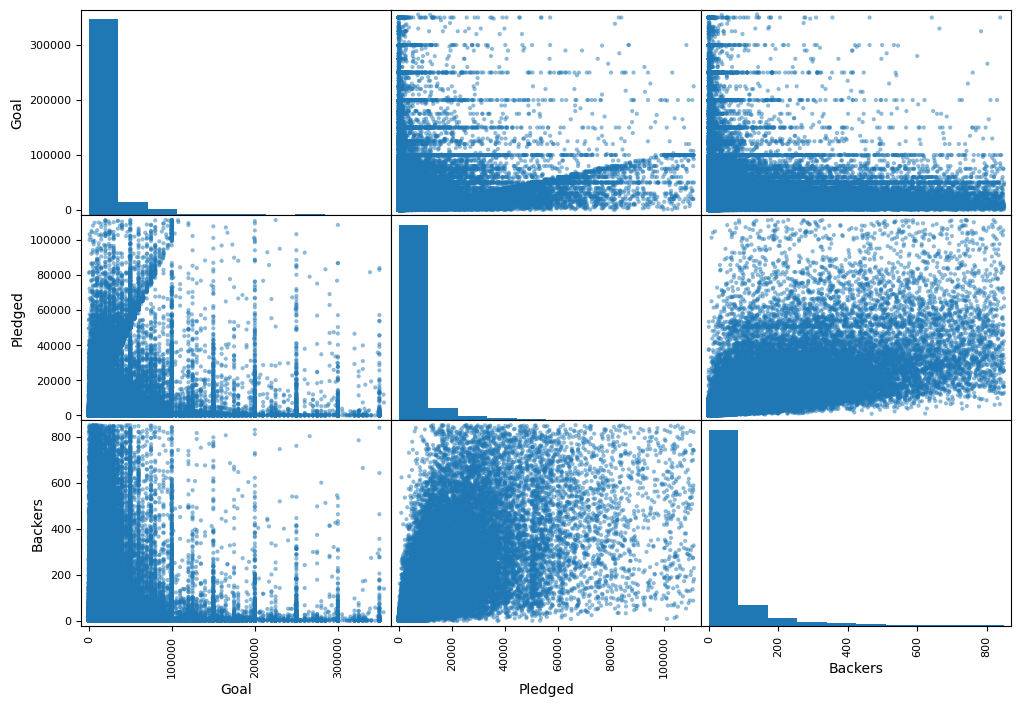

In [700]:
# Importe la fonction scatter_matrix depuis pandas.plotting
from pandas.plotting import scatter_matrix

# Défini les attributs que nous souhaitons inclure dans la matrice de dispersion
attributs = ['Goal', 'Pledged', 'Backers']

# Crée et afficher la matrice de dispersion avec les attributs spécifiés
scatter_matrix(train_set[attributs], figsize=(12, 8))

In [701]:
''' 
NOTE : Comme nous pouvions le croire, il semble y avoir un risque de confounding variables entre les variables Pledged et Backers.
Il est logique de croire, que plus il y a de gens qui supportent un projet, plus d'argent sera amassé. Les facteurs de confusion 
surcomplexifie un modèle en ajoutant de la redondance d'information. Une des deux variables soit doit être retirée, ou un facteur
d'intéraction peut être ajouté. 
'''

corr_pledged_backers = train_set['Pledged'].corr(train_set['Backers'])
print(f'La corrélation entre Pledged et Backers est de {corr_pledged_backers:.2%}')

La corrélation entre Pledged et Backers est de 74.98%


In [702]:
corr_pledged_backers = train_set['Pledged'].corr(train_set['Goal'])
print(f'La corrélation entre Pledged et Goal est de {corr_pledged_backers:.2%}')

La corrélation entre Pledged et Goal est de 15.04%


In [703]:
corr_pledged_backers = train_set['Backers'].corr(train_set['Goal'])
print(f'La corrélation entre Backers et Goal est de {corr_pledged_backers:.2%}')

La corrélation entre Backers et Goal est de 4.13%


In [704]:
# Création d'un facteur d'interaction entre Pledged et Backers.
train_set['Pledged_Backers'] = train_set['Pledged'] * train_set['Backers']
train_set['log_Pledged_Backers'] = train_set['log_Pledged'] * train_set['log_Backers']
train_set['sqrt_Pledged_Backers'] = train_set['sqrt_Pledged'] * train_set['sqrt_Backers']

In [705]:
# Recalcul de la matrice de corrélation pour l'ensemble de données d'entraînement.
corr_matrix = train_set.corr()
corr_matrix['Success'].sort_values(ascending=False)

/var/folders/5c/s5mcxltd5tl3kzp0vbb_0vlw0000gn/T/ipykernel_9441/1742408484.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_set.corr()


Success                 1.000000
log_Backers             0.642009
log_Pledged_Backers     0.638835
sqrt_Backers            0.621533
log_Pledged             0.584147
sqrt_Pledged            0.574444
Backers                 0.459074
sqrt_Pledged_Backers    0.454327
Pledged                 0.388007
Pledged_Backers         0.245526
LengthName              0.082232
HourLaunched            0.005155
ID                      0.000224
WeekdayLaunched        -0.007667
DayLaunched            -0.014732
MonthLaunched          -0.025222
CountDay               -0.109539
DateDiff               -0.114736
YearLaunched           -0.140010
CountYear              -0.140037
CountMonth             -0.141076
Goal                   -0.200495
log_Goal               -0.245797
sqrt_Goal              -0.251136
Name: Success, dtype: float64

# **Étape 9 : Préparation des données pour le ML**

Il est temps de préparer les données pour les algorithmes d'apprentissage machine. Au lieu de le faire manuellement, on va écrire des fonctions et des classes pour le faire, conformément aux pratiques de programmation fonctionnelle et orientée objet. Voici les variables que nous sélectionnerons pour notre première itération du modèle : quatre variables de base (Category, MainCategory, Currency, Country) et des variables personnalisées que nous trouvons intéressantes (DateDiff, sqrt_Goal, sqrt_Backers, sqrt_Pledged_Backers).

La sélection des variables a été complétée suite aux résultats de l'analyse exploratoire et dans l'objectif de limiter le nombre de features dans le modèle pour le simplifier.

In [706]:
# Séparer les datasets en features et labels pour les transformations.
X_train = strat_train_set.drop('Success', axis=1)
y_train = strat_train_set['Success'].copy()

In [707]:
X_train.head(1)

,ID,Name,Category,MainCategory,Currency,Deadline,Goal,Launched,Pledged,Backers,Country
154406,1947487012,glacious le the first affordable 60mm ice sphe...,Product Design,Design,USD,2014-12-25 18:56:41,10000.0,2014-11-25 18:56:41,15962.0,128,US


In [708]:
# Crée une classe personnalisée pour effectuer les transformation nécessaires et créer des features numériques.
from sklearn.base import BaseEstimator, TransformerMixin

class FeaturesGenerator(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop, add_date_diff = True, sqrt_goal = True, sqrt_backers = True, interaction_sqrt=True):
        self.add_date_diff = add_date_diff
        self.sqrt_goal = sqrt_goal
        self.sqrt_backers = sqrt_backers
        self.interaction_sqrt = interaction_sqrt
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()

        # Ajoute la variable DateDiff, si True
        if self.add_date_diff:
            for column in ['Deadline','Launched']:
                X_copy[column] = pd.to_datetime(X_copy[column], format='%Y-%m-%d %H:%M:%S')
            
            X_copy['DateDiff'] = (X_copy['Deadline'] - X_copy['Launched']).dt.days
        
        # Ajoute la variable sqrt_Goal, si True
        if self.sqrt_goal:
            X_copy['sqrt_Goal'] = np.sqrt(X_copy['Goal'].astype(int))

        # Ajoute la variable sqrt_Backers, si True      
        if self.sqrt_backers:
            X_copy['sqrt_Backers'] = np.sqrt(X_copy['Backers'].astype(int))

        # Ajoute la variable sqrt_Pledged_Backers, si True      
        if self.interaction_sqrt:
            X_copy['sqrt_Pledged_Backers'] = np.sqrt(X_copy['Backers'].astype(int))*np.sqrt(X_copy['Pledged'].astype(int))
        
        X_copy = X_copy.drop(columns=self.columns_to_drop)

        return X_copy

In [709]:
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_features = ['DateDiff','sqrt_Goal','sqrt_Backers','sqrt_Pledged_Backers']
cat_features = ['Category','MainCategory','Currency','Country']

full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_features),
        ("encoder", OneHotEncoder(), cat_features)
    ])

X_train_preprepared = FeaturesGenerator(columns_to_drop=['ID','Name','Deadline','Goal','Launched','Pledged']).transform(X_train)
X_train_prepared = full_pipeline.fit_transform(X_train_preprepared)

# **Étape 10 : Sélection et entraînement du modèle ML**

In [710]:
# Commençons par une régression logistique.
from sklearn.linear_model import LogisticRegression

log_classifier = LogisticRegression(max_iter=1000)
log_classifier.fit(X_train_prepared, y_train)

LogisticRegression(max_iter=1000)

Training Set Performance:
Accuracy: 93.73%
Precision: 0.91
Recall: 0.90
F1 Score: 0.91
ROC-AUC Score: 0.98


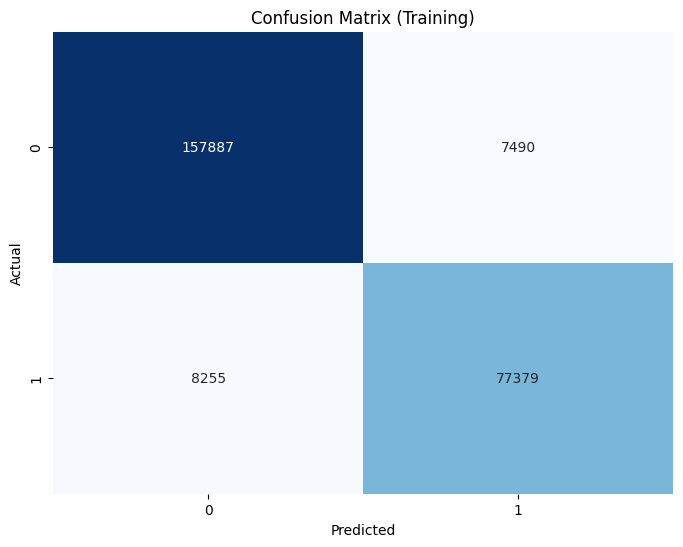

In [711]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_classifier(classifier, X, y, dataset_name, roc=0):

    # Applique les transformation au dataset
    X_preprepared = FeaturesGenerator(columns_to_drop=['ID','Name','Deadline','Goal','Launched','Pledged']).transform(X)
    X_prepared = full_pipeline.fit_transform(X_preprepared)

    # Prédit les valeurs
    y_pred = classifier.predict(X_prepared)

    # Calcule les statistiques
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    if roc == 1:
        roc_auc = roc_auc_score(y, classifier.predict_proba(X_prepared)[:, 1])

    print("{} Set Performance:".format(dataset_name))
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))
    if roc == 1:
        print("ROC-AUC Score: {:.2f}".format(roc_auc))

    # Crée une matrice de confusion
    conf_matrix = confusion_matrix(y, y_pred)

    # Plot la matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix ({})'.format(dataset_name))
    plt.show()

evaluate_classifier(log_classifier, X_train, y_train, "Training",roc=1)


Testing Set Performance:
Accuracy: 93.96%
Precision: 0.92
Recall: 0.91
F1 Score: 0.91
ROC-AUC Score: 0.98


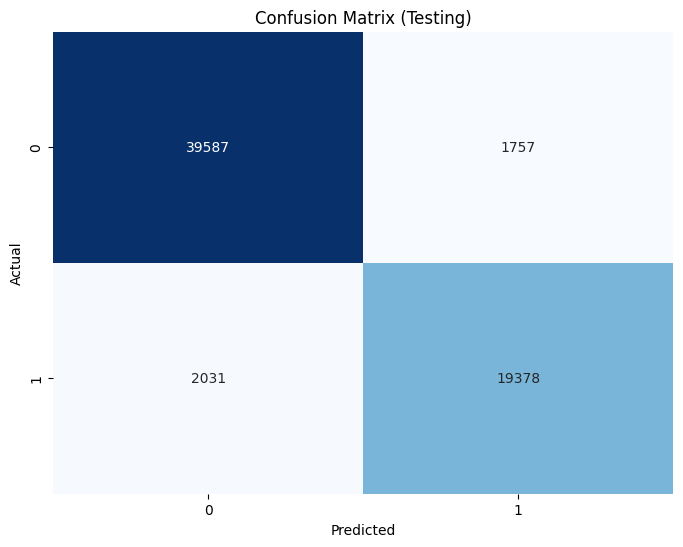

In [712]:
evaluate_classifier(log_classifier, X_test, y_test, "Testing", roc=1)

In [713]:
# Essayons une classification par vecteur avec SVC
from sklearn.svm import SVC

svc_classifier = SVC()
svc_classifier.fit(X_train_prepared, y_train)

SVC()

Training Set Performance:
Accuracy: 98.58%
Precision: 0.97
Recall: 0.99
F1 Score: 0.98


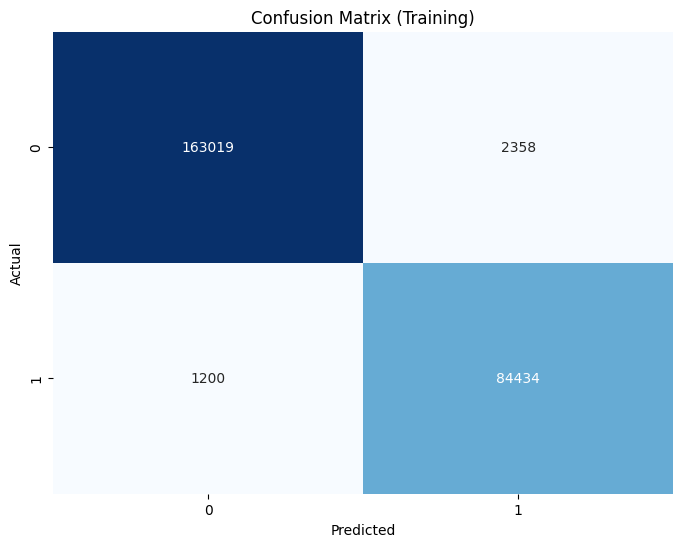

In [714]:
evaluate_classifier(svc_classifier, X_train, y_train, "Training", roc=0)

Testing Set Performance:
Accuracy: 98.56%
Precision: 0.97
Recall: 0.99
F1 Score: 0.98


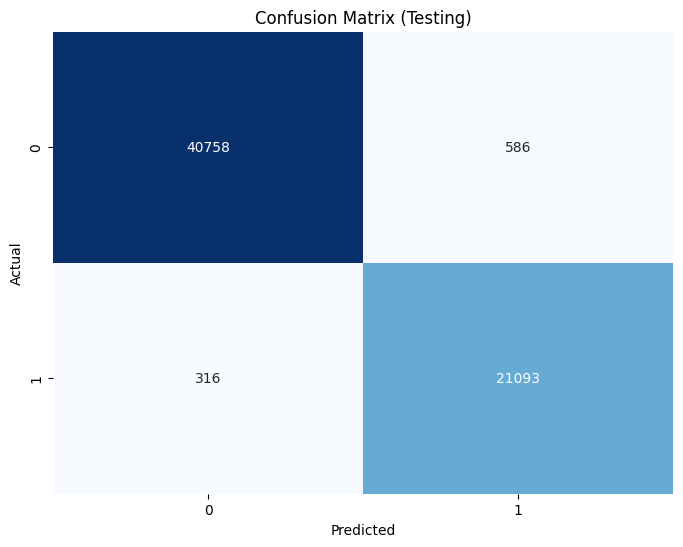

In [715]:
evaluate_classifier(svc_classifier, X_test, y_test, "Testing", roc=0)

In [716]:
# Essayons une classification par arbre de décision 
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=123)
dt_classifier.fit(X_train_prepared, y_train)

DecisionTreeClassifier(random_state=123)

Training Set Performance:
Accuracy: 99.97%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


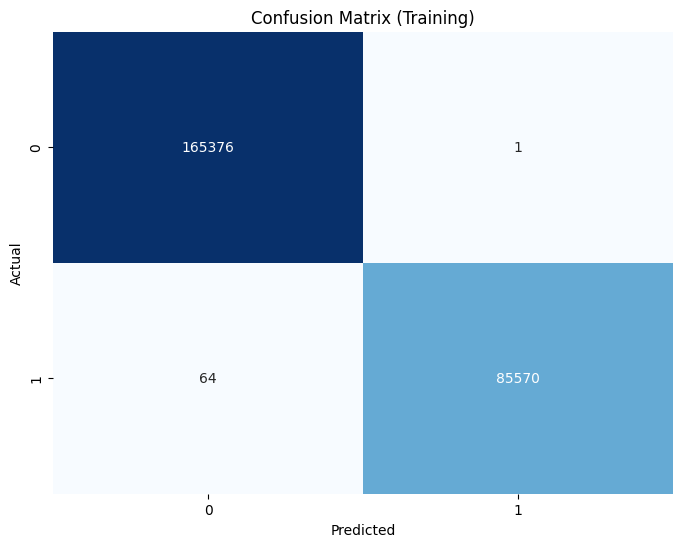

In [717]:
evaluate_classifier(dt_classifier, X_train, y_train, "Training", roc=0)

Testing Set Performance:
Accuracy: 98.35%
Precision: 0.98
Recall: 0.97
F1 Score: 0.98


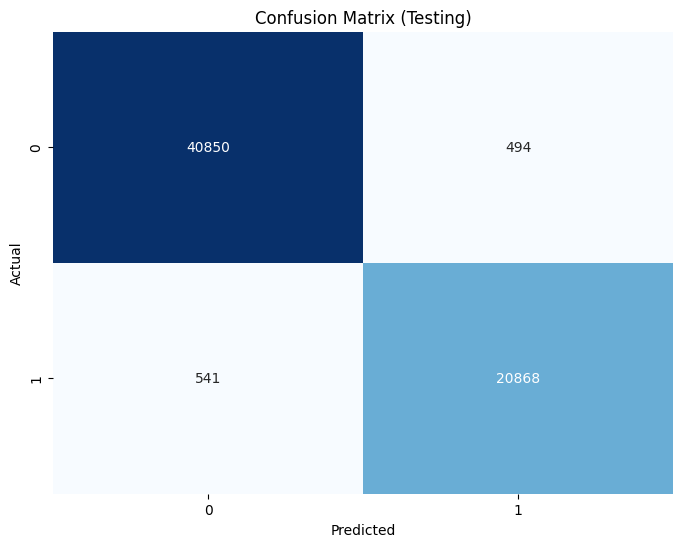

In [718]:
evaluate_classifier(dt_classifier, X_test, y_test, "Testing", roc=0)

À ce point, nous avons évalué trois modèles de classification qui affichent une haute précision, voire même trop haute. Mon hypothèse est que les facteurs de confusion (Backed et Pledged) sont trop importants et faussent les résultats de l'évaluation des modèles. Un atout intéressant de l'arbre de décision est qu'on peut facilement voir quels features ont le plus d'incidence sur la variable indépendante (grâce à la fonction feature_importances_) et potentiellement confirmer mon hypothèse. Faisons-le.

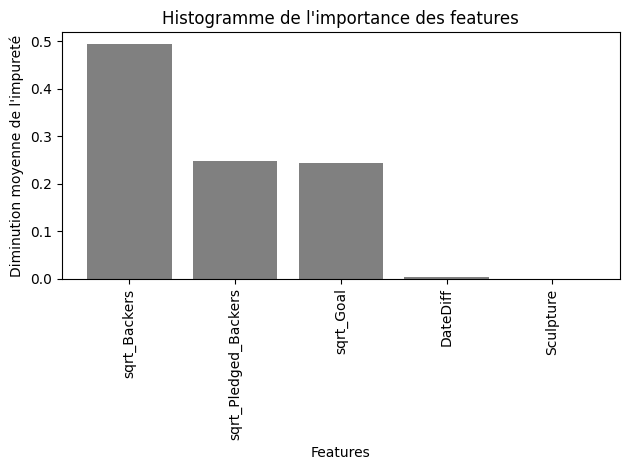

In [719]:
def top_features(extra_attribs, top_n):
    importances = dt_classifier.feature_importances_

    cat_encoder = full_pipeline.named_transformers_["encoder"]
    cat_one_hot_attribs = list(cat_encoder.categories_[0])
    attributes = num_features + extra_attribs + cat_one_hot_attribs

    data = sorted(zip(importances, attributes), reverse=True)
    data_top = data[:top_n]

    # Extracte les valeurs de data_top_5
    values = [item[0] for item in data_top]
    labels = [item[1] for item in data_top]

    # Crée un histogramme
    plt.bar(labels, values, color='gray')
    plt.xlabel('Features')
    plt.ylabel('Diminution moyenne de l\'impureté')
    plt.title('Histogramme de l\'importance des features')
    plt.xticks(rotation=90) 

    plt.tight_layout()
    plt.show()

top_features(extra_attribs=["DateDiff", "sqrt_Goal", "sqrt_Backers","sqrt_Pledged_Backers"], top_n=5)

Comme illustré dans le graphique ci-dessus, la haute performance des modèles s'explique par l'inclusion de facteurs de confusion tels que Backers et Pledged, qui sont essentiellement synonymes de succès. Pour la suite du processus de conception du modèle, nous retirons ces variables et ré-entraînons le modèle d'arbre de décision. 

# **Étape 11 : Sélection des variables explicatives pertinentes**

Pour réduire l'effet des variables de confusion et l'overfitting, il est important d'inclure dans le modèle uniquement les variables explicatives pertinentes pour que le modèle capte l'information nécessaire à la généralisation sur un set de données inconnues, comme le test set. C'est pour cette raison que nous appliquons une méthode de sélection des variables, en commençant par le retrait des facteurs de confusion.

In [720]:
'''
NOTE : Pour effectuer le retrait, nous corrigeons la variable num_features (en retirant sqrt_Backers et sqrt_Pledged_Backers) et
changeons les paramètres sqrt_backers et interaction_sqrt de FeaturesGenerator à False. 
'''

# Liste les variables qui vont être transformées dans le pipeline
num_features = ['DateDiff','sqrt_Goal']
cat_features = ['Category','MainCategory','Currency','Country']

full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_features),
        ("encoder", OneHotEncoder(), cat_features)
    ])

X_train_preprepared = FeaturesGenerator(columns_to_drop=['ID','Name','Deadline','Goal','Launched','Pledged'],
                                    sqrt_backers=False, 
                                    interaction_sqrt=False).transform(X_train)
X_train_prepared = full_pipeline.fit_transform(X_train_preprepared)

In [721]:
# Essayons une classification par arbre de décision 
dt_classifier = DecisionTreeClassifier(random_state=123)
dt_classifier.fit(X_train_prepared, y_train)

DecisionTreeClassifier(random_state=123)

Training Set Performance:
Accuracy: 83.50%
Precision: 0.85
Recall: 0.62
F1 Score: 0.72


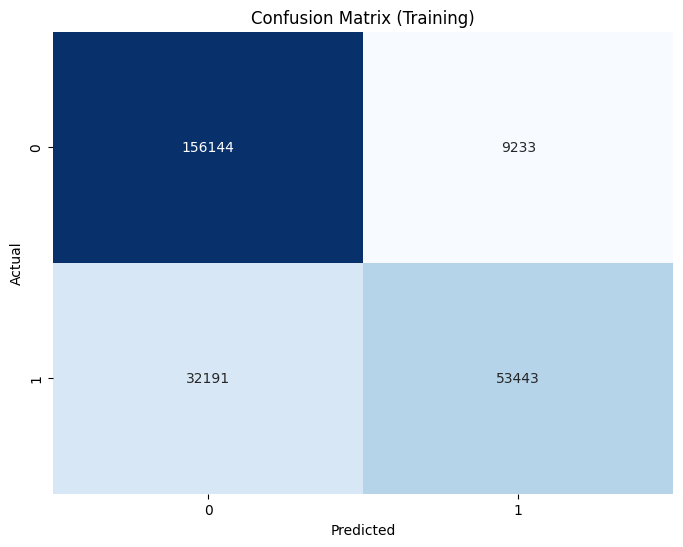

In [722]:
evaluate_classifier(dt_classifier, X_train, y_train, "Training", roc=0)

Testing Set Performance:
Accuracy: 65.78%
Precision: 0.50
Recall: 0.40
F1 Score: 0.45


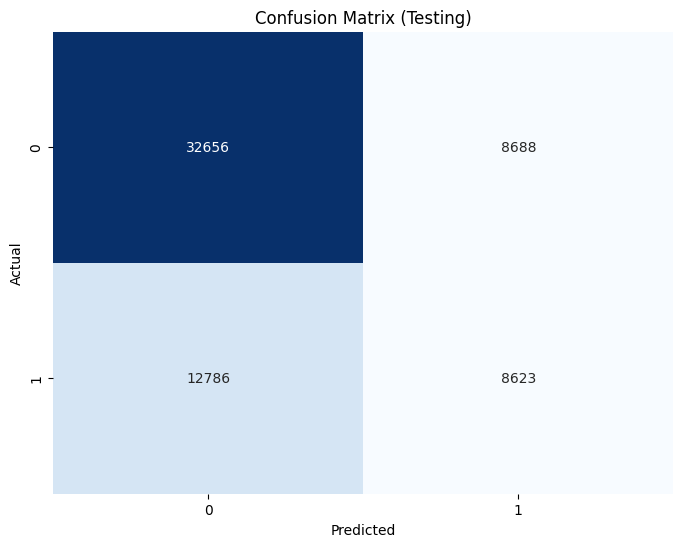

In [723]:
evaluate_classifier(dt_classifier, X_test, y_test, "Testing", roc=0)

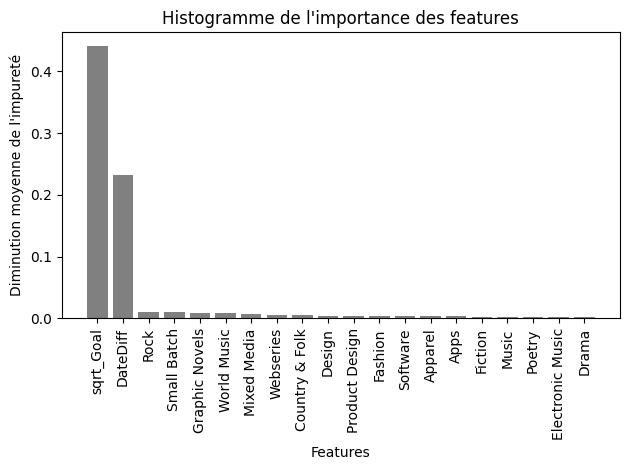

In [724]:
top_features(extra_attribs=["DateDiff", "sqrt_Goal"], top_n=20)

Bonne nouvelle! Notre hypothèse concernant les facteurs de confusion était bonne. Cependant un problème demeure, notre modèle semble performer beaucoup mieux sur notre training set que sur notre testing set. Ceci peut être dû à de l'overfitting, c'est-à-dire que notre modèle d'apprentissage machine apprend trop bien les données d'entraînement, au point de mémoriser le bruit ou les fluctuations aléatoires dans les données au lieu de généraliser des motifs utiles. Cela est dû à une surcomplexification du modèle par l'intégration de beaucoup de variables inutiles. 

En effet, notre modèle contient un grand nombre de variables (116), qui sont peu ou pas du tout utile pour expliquer la variable indépendante. Essayons d'en retirer quelques-unes et ré-entraîner le modèle. 

In [725]:
# Commençons par éliminer les features dont la variance est nulle alors qu'ils apportent aucune valeur informationnelle.
from sklearn.feature_selection import VarianceThreshold

sel_variance_threshold = VarianceThreshold() 
X_train_remove_variance = sel_variance_threshold.fit_transform(X_train_prepared)

X_train_remove_variance.shape
# Aucune variable n'a été retirée.

(251011, 116)

In [726]:
'''
NOTE : Puisqu'aucun feature n'a une variance de 0, nous devons être plus sévère dans notre sélection en implantant un threshold de 
d'importance à appliquer. L'importance relative des features est utile à l'implantation de ce threshold alors qu'elle indique la 
diminution moyenne de l'impureté associé à un feature donné. Ce threshold peut ensuite être utilisé dans des méthodes de sélection de
variables comme le VarianceThreshold (ou le SelectFromModel) de sklearn.feature_selection.
'''

importances = dt_classifier.feature_importances_

# Démontre, sous forme de liste, l'importance relative de chacun des features.
np.round(importances, 3)

array([0.233, 0.441, 0.002, 0.002, 0.002, 0.002, 0.003, 0.003, 0.003,
       0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.005, 0.002, 0.001,
       0.005, 0.002, 0.002, 0.003, 0.003, 0.003, 0.004, 0.003, 0.001,
       0.001, 0.002, 0.001, 0.001, 0.002, 0.009, 0.002, 0.003, 0.003,
       0.002, 0.001, 0.002, 0.001, 0.006, 0.002, 0.003, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.002, 0.001, 0.002, 0.002, 0.003, 0.002,
       0.004, 0.001, 0.003, 0.002, 0.011, 0.002, 0.002, 0.01 , 0.003,
       0.001, 0.003, 0.002, 0.003, 0.001, 0.006, 0.008, 0.001, 0.003,
       0.005, 0.004, 0.006, 0.003, 0.003, 0.002, 0.015, 0.002, 0.004,
       0.003, 0.013, 0.003, 0.005, 0.   , 0.001, 0.004, 0.007, 0.   ,
       0.   , 0.   , 0.001, 0.001, 0.   , 0.011, 0.001, 0.003, 0.001,
       0.005, 0.001, 0.002, 0.001, 0.002, 0.003, 0.007, 0.   , 0.001,
       0.002, 0.   , 0.002, 0.   , 0.001, 0.001, 0.   , 0.008])

In [727]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel

# Défini un liste de 100 threshold à tester
thresholds = np.linspace(0, max(importances), 100)  

best_threshold = None
best_score = 0

# Teste la performance du dt_classifier avec différentes valeur de threshold
for threshold in thresholds:
    sfm = SelectFromModel(dt_classifier, threshold=threshold)
    X_train_selected = sfm.transform(X_train_prepared)
    
    # Évalue la performance du modèle avec le threshold spécifique en appliquant la validation croisée.
    scores = cross_val_score(dt_classifier, X_train_selected, y_train, cv=5)
    mean_score = np.mean(scores)
    
    if mean_score > best_score:
        best_score = mean_score
        best_threshold = threshold

print(f"Le meilleur threshold est : {best_threshold}")

'''
NOTE : La validation croisée est une technique pertinente qui teste la performance d'un modèle en séparant le training set en n nombre
de subsets qui sont définis par le paramètre cv, dans la méthode cross_val_score. L'avantage de cette méthode est qu'elle offre une plus
grandre précision. Un désavantage est qu'elle est plus demandante au niveau computationnelle. 
'''

Le meilleur threshold est : 0.004456529837590483


"\nNOTE : La validation croisée est une technique pertinente qui teste la performance d'un modèle en séparant le training set en n nombre\nde subsets qui sont définis par le paramètre cv, dans la méthode cross_val_score. L'avantage de cette méthode est qu'elle offre une plus\ngrandre précision. Un désavantage est qu'elle est plus demandante au niveau computationnelle. \n"

In [728]:
# Liste les variables qui vont être transformées dans le pipeline
num_features = ['DateDiff','sqrt_Goal']
cat_features = ['Category','MainCategory','Currency','Country']

full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_features),
        ("encoder", OneHotEncoder(), cat_features)
    ])

# Transformation des variables de training
X_train_preprepared = FeaturesGenerator(columns_to_drop=['ID','Name','Deadline','Goal','Launched','Pledged'],
                                    sqrt_backers=False, 
                                    interaction_sqrt=False).transform(X_train)
X_train_prepared = full_pipeline.fit_transform(X_train_preprepared)

X_train_selected = SelectFromModel(dt_classifier, threshold=best_threshold).transform(X_train_prepared)

# Transformation des variables de testing
X_test_preprepared = FeaturesGenerator(columns_to_drop=['ID','Name','Deadline','Goal','Launched','Pledged'],
                                    sqrt_backers=False, 
                                    interaction_sqrt=False).transform(X_test)
X_test_prepared = full_pipeline.fit_transform(X_test_preprepared)

X_test_selected = SelectFromModel(dt_classifier, threshold=best_threshold).transform(X_test_prepared)

In [729]:
# Essayons une classification par arbre de décision 
dt_classifier = DecisionTreeClassifier(random_state=123)
dt_classifier.fit(X_train_selected, y_train)

DecisionTreeClassifier(random_state=123)

Accuracy: 78.41%
Precision: 0.79
Recall: 0.50
F1 Score: 0.61


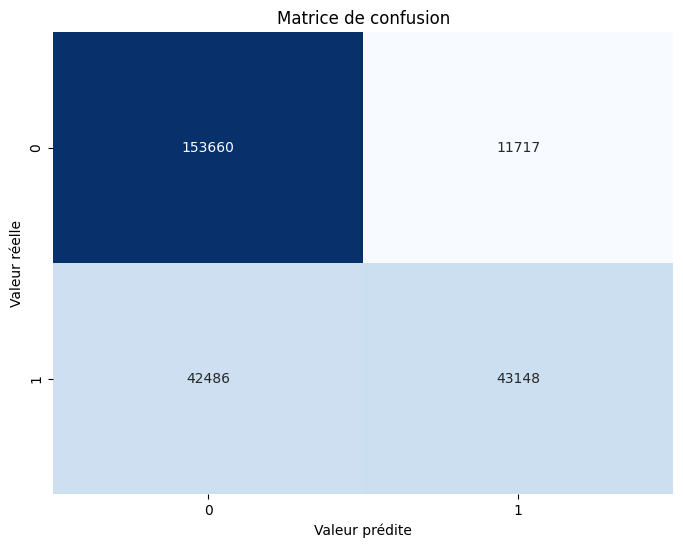

In [730]:
def eval_model(model, X, y):
    y_pred = model.predict(X)

    # Calcule les mesures de performance.
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    confusion = confusion_matrix(y, y_pred)

    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))

    # Matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Valeur prédite')
    plt.ylabel('Valeur réelle')
    plt.title('Matrice de confusion')
    plt.show()

eval_model(dt_classifier, X_train_selected, y_train)

Accuracy: 64.49%
Precision: 0.48
Recall: 0.39
F1 Score: 0.43


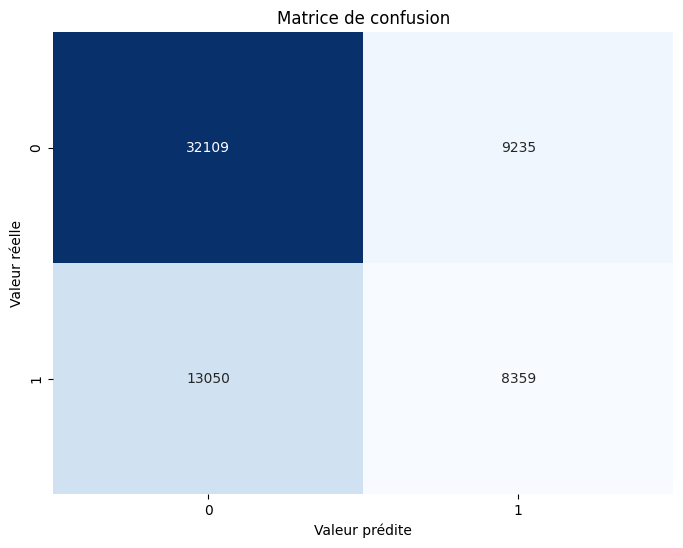

In [731]:
eval_model(dt_classifier, X_test_selected, y_test)

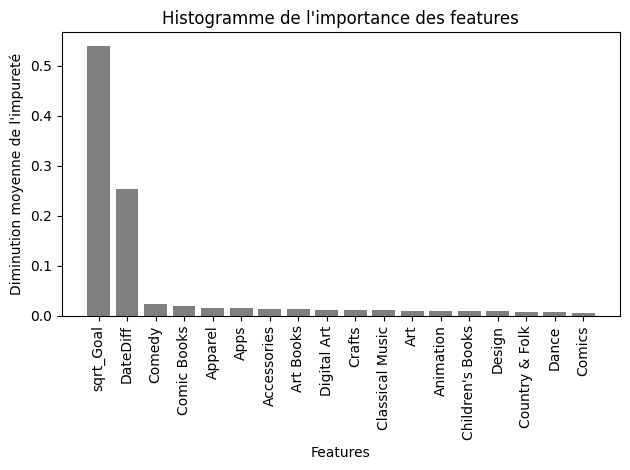

In [732]:
# Top_n = 100 est une valeur utilisée uniquement pour sélectionner le max nombre de features.
top_features(extra_attribs=["DateDiff", "sqrt_Goal"], top_n=100)

Dans les itérations futures, nous pourrions essayer différentes méthodes de sélection des variables, comme le Stepwise selection (regression). Différentes méthodes de sélection peuvent produire différents résultats et la comparaison entre ces méthodes, peut permettre d'améliorer la performance du modèle. Tout de même, en appliquant un threshold de ~0.00445 dans la sélection par SelectFromModel, nous obtenons un modèle avec 18 variables explicatives. Voyons maintenant quels hyperparamètres maximiseraient la performance. 

# **Étape 12 : Sélection des paramètres optimaux du modèle choisi**

In [733]:
from sklearn.model_selection import GridSearchCV

# Défini les valeurs possibles pour les hyperparamètres.
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crée un GridSearchCV avec une mesure de précision mesurée en validation croisée
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit les résultats du GridSearchCV aux données d'entraînement
grid_search.fit(X_train_selected, y_train)

# Enregistre les meilleurs paramètres et le meilleur modèle.
best_params = grid_search.best_params_
best_classifier = grid_search.best_estimator_

# Imprime les meilleurs paramètres
print("Best Hyperparameters:")
print(best_params)


Best Hyperparameters:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}


Accuracy: 70.43%
Precision: 0.63
Recall: 0.33
F1 Score: 0.43


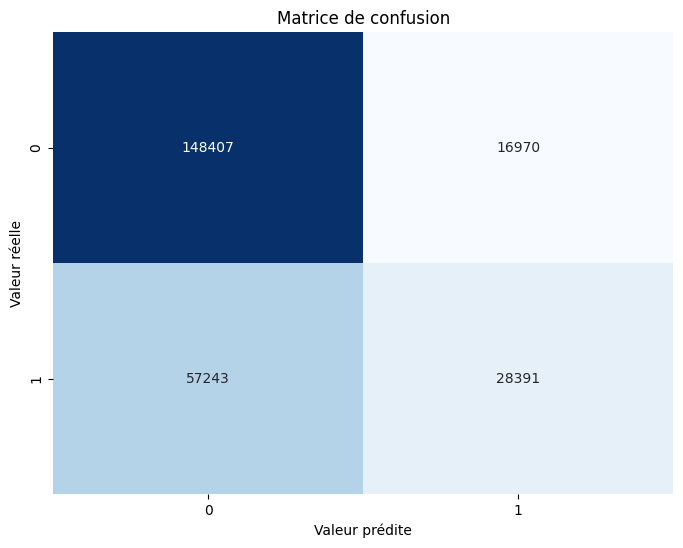

In [734]:
eval_model(best_classifier, X_train_selected, y_train)

Accuracy: 70.07%
Precision: 0.62
Recall: 0.33
F1 Score: 0.43


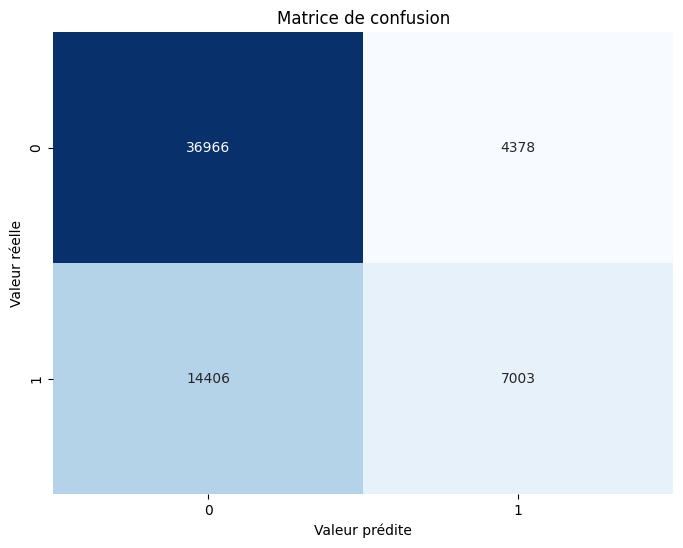

In [735]:
eval_model(best_classifier, X_test_selected, y_test)

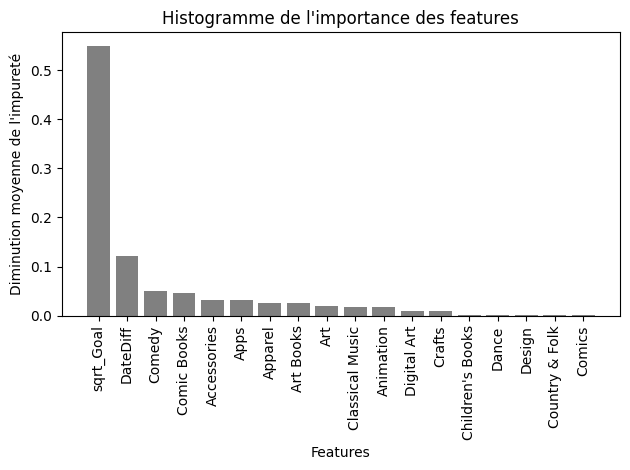

In [736]:
def top_features(extra_attribs, top_n):
    importances = best_classifier.feature_importances_

    cat_encoder = full_pipeline.named_transformers_["encoder"]
    cat_one_hot_attribs = list(cat_encoder.categories_[0])
    attributes = num_features + extra_attribs + cat_one_hot_attribs

    data = sorted(zip(importances, attributes), reverse=True)
    data_top = data[:top_n]

    # Extracte les valeurs de data_top_5
    values = [item[0] for item in data_top]
    labels = [item[1] for item in data_top]

    # Crée un histogramme
    plt.bar(labels, values, color='gray')
    plt.xlabel('Features')
    plt.ylabel('Diminution moyenne de l\'impureté')
    plt.title('Histogramme de l\'importance des features')
    plt.xticks(rotation=90) 

    plt.tight_layout()
    plt.show()

top_features(extra_attribs=["DateDiff", "sqrt_Goal"], top_n=20)

Voici un premier modèle où la généralisation de l'apprentissage ne mène pas à une divergence entre les résultats de prédiction entre le testing et le training set. Cela indique que nous avons réduit l'overfitting et sommes présentement en situation de underfitting (puisqu'avec les variables existantes, la performance du modèle semble encore insuffisamment élevée). Pour résoudre ce problème, il est important de revenir sur les étapes précédentes en essayant de créer des nouveaux features, de joindre des données supplémentaires et de simplement enrichir le modèle de variables qui peuvent expliquer les facteurs de succès d'une campagne Kickstarter. 

# **Étape 13 : Lancer, surveiller et maintenir la solution ML**

Une fois approuvé par le client, nous devons préparer notre solution pour la production, en particulier en connectant les sources de données d'entrée de production à notre système et en écrivant des tests de validation de la performance et de la qualité des données.

Nous devons rédiger du code de surveillance pour vérifier la performance en direct et à intervalles réguliers, puis déclencher des alertes en cas de baisse de performance. Cela est important non seulement pour détecter les pannes soudaines, mais aussi pour effectuer des corrections au nécessaire. Cela est assez courant car les modèles ont tendance à se "dégrader" à mesure que les données évoluent avec le temps, à moins qu'ils ne soient régulièrement entraînés avec des données fraîches.